In [1]:
!pip install xgboost

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('data_processed.csv')
df.head()

,offer_id,account_id,event,time_since_test_start,ammount,reward,age,credit_card_limit,gender,registered_on,discount_value,duration,min_value,offer_type,web,email,mobile,social
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,NaN,NaN,75,100000.0,F,2017-05-09,5.0,7.0,5.0,bogo,1.0,1.0,1.0,0.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,NaN,NaN,118,NaN,NaN,2017-08-04,5.0,10.0,20.0,discount,1.0,1.0,0.0,0.0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,offer received,0.0,NaN,NaN,68,70000.0,M,2018-04-26,2.0,7.0,10.0,discount,1.0,1.0,1.0,0.0
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,NaN,NaN,118,NaN,NaN,2017-09-25,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,NaN,NaN,118,NaN,NaN,2017-10-02,10.0,5.0,10.0,bogo,1.0,1.0,1.0,1.0


# Criando o label

In [4]:
df_received = df[df['event'] == 'offer received'].copy()

In [5]:
df_completed = df[df['event'] == 'offer completed']

In [6]:
df_received['offer_completed'] = df_received.apply(
    lambda row: 1 if ((df_completed['account_id'] == row['account_id']) & 
                      (df_completed['offer_id'] == row['offer_id'])).any() else 0,
    axis=1
)

# Filtro de ofertas que não sejam de informação

In [7]:
df_model = df_received[df_received['offer_type'] != 'informational'].copy()

# Codificação e seleção de features

In [8]:
df_model = pd.get_dummies(df_model, columns=['gender'], prefix='gender')
df_model = pd.get_dummies(df_model, columns=['offer_type'], prefix='offer_type')

In [9]:
features = [
    'age', 'credit_card_limit', 'reward', 'discount_value', 'duration',
    'min_value', 'web', 'email', 'mobile', 'social',
    'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo', 'offer_type_discount'
]

In [10]:
X = df_model[features]
y = df_model['offer_completed']

# Split de dados em treino e teste

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo

In [12]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Métricas/Avaliação

In [13]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Acurácia: 0.7264
Precisão: 0.7348
Recall: 0.8418
F1 Score: 0.7847


Interpretabilidade das métricas: 
- Precision alta: menos envio de cupons "inúteis" → economia com descontos.
- Recall alto: mais clientes que converteriam sendo atingidos → mais receita.

Ou seja:
O modelo (F1 = 0.78) identifica 78% dos casos positivos de forma eficiente. 
O que pode reduzir desperdício de envio de ofertas
& aumentar conversões, assim impactando diretamente a receita.

# Importâncida das features / Interpretabilidade

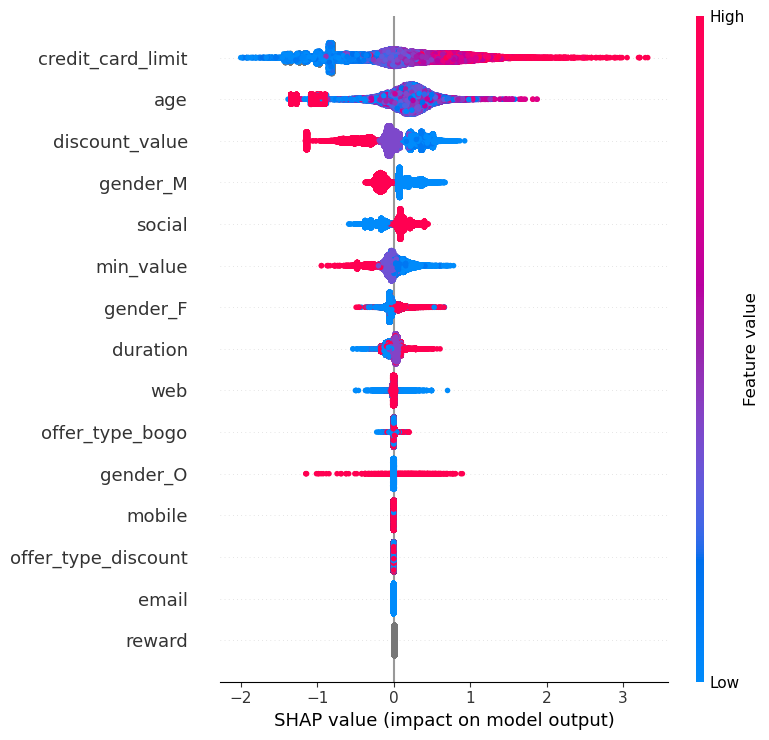

In [14]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

Features:
- credit_card_limit
    - Impacto mais significativo no modelo.
    - Valores altos de limite (pontos vermelhos) estão associados a SHAP positivos: clientes com maior limite tendem a completar mais ofertas.
     - Valores baixos (pontos azuis) podem reduzir a probabilidade de conversão.

- age
    - SHAP positivo: clientes mais velhos têm maior propensão a completar ofertas.
    - Distribuição concentrada à direita sugere que idade é um fator consistente para conversão.

- discount_value
    - Descontos maiores estão correlacionados com maior taxa de conversão (como esperado).

- canais de marketing
    - social e web: impacto positivo moderado. Ofertas veiculadas por redes sociais e web são mais efetivas.
    - mobile e email: impacto próximo de zero. Sugere que esses canais são menos eficazes para conversão.

- gênero
     - homens respondem melhor às ofertas que mulheres ou nulos.


Insights:
- Priorização de clientes com alto limite de cartão e idade mais avançada.
- Reduza o min_value exigido para ativar ofertas.
- Usar canais sociais e web para veiculação.